In [1]:
from ase.build import bulk, make_supercell
import numpy as np

from HopDec.ASE import *
from HopDec.Input import *
from HopDec.Lammps import *
from HopDec.State import *

import HopDec.Redecorate as Redecorate
import HopDec.Minimize as Minimize
import HopDec.NEB as NEB
import HopDec.MD as MD

%matplotlib inline
import matplotlib.pyplot as plt

# Generate Initial Structure (Vacancy in Pure Cu)

In [2]:
# Generate simple ASE structure

CuPrim = bulk('Cu', 'fcc', a=3.6, cubic=True)
CuPrim.cell
CuSuperCell = make_supercell(CuPrim, np.array([[5,0,0],[0,5,0],[0,0,5]]))

In [3]:
# Create Vacancy in supercell
del CuSuperCell[249]

In [4]:
CuSuperCell

Atoms(symbols='Cu499', pbc=True, cell=[18.0, 18.0, 18.0])

# Pass to Hop Dec

In [5]:
params = getParams()

In [6]:
# Initialize HopDec and transform ASE structure to State object

ase = ASE(params)
initialState = ase.toState(CuSuperCell)
initialState

In [9]:
# mininize State in-place

lmp = LammpsInterface(params)
Minimize.main(initialState, params, lmp = lmp, verbose = True)

[16/05/24, 13:08:03]:   Lammps >> Minimizing. F Tol: 1e-05.
[16/05/24, 13:08:03]: Lammps >> Completed Minimization, E: -1764.8919 eV


# Find Transition

In [11]:
flag = 0
_, newState, flag = MD.main(initialState, params)

In [13]:
connection = NEB.main(initialState, newState, params, exportStructures = True, plotPathways = True, verbose = True) # run a NEB between these two states

[16/05/24, 13:08:16]: NEB >> Minimizing End Points
[16/05/24, 13:08:16]:   Lammps >> Minimizing. F Tol: 1e-05.
[16/05/24, 13:08:16]: Lammps >> Completed Minimization, E: -1764.8919 eV
[16/05/24, 13:08:16]:   Lammps >> Minimizing. F Tol: 1e-05.
[16/05/24, 13:08:16]: Lammps >> Completed Minimization, E: -1764.8919 eV
[16/05/24, 13:08:16]: NEB >> Initializing ASE Structure
[16/05/24, 13:08:16]: NEB >> Interpolating 11 images
[16/05/24, 13:08:16]: NEB >> Performing NEB. Force Tol: 0.1, Transition:
        ab2d71d992015e18300c2bc311585706 -> ab2d71d992015e18300c2bc311585706
[16/05/24, 13:08:19]: NEB >> NEB finished Successfully. Extracting Results
[16/05/24, 13:08:19]: NEB >> Checking NEB path for integrity
[16/05/24, 13:08:19]: NEB >> Found Intermediate Minima, Requeueing...
[16/05/24, 13:08:19]: NEB >> Minimizing End Points
[16/05/24, 13:08:19]:   Lammps >> Minimizing. F Tol: 1e-05.
[16/05/24, 13:08:19]: Lammps >> Completed Minimization, E: -1764.8919 eV
[16/05/24, 13:08:19]:   Lammps >> 

In [ ]:
connection.transitions[0].forwardBarrier

0.7065

# Redecorate Transition

In [ ]:
# Given that we have found a valid Connection / Transition.
# We may want to run a redecoration campaign
# This one will take the States defined and conduct 10 NEBS (controlled in config file) 
# with redecoration of the atoms as either Cu or Ni at 50:50 concentrations (controlled in config file).
# Then return a results object
params.nDecorations = 2
redecResults = Redecorate.main(connection.transitions[0], params, pickle = False)


[16/05/24, 12:57:23]: Redecorate >> Starting NEB Redecoration Campaign
[16/05/24, 12:57:23]:   Redecorate >> rank: 0: Redecoration: 1
[16/05/24, 12:57:24]:   Redecorate >> rank: 0: Redecoration: 2


/Users/peterhatton/Desktop/git/Hop-Decorate/HopDec/Redecorate.py:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,row], ignore_index=True)


In [ ]:
# The redecoration results contains 10 'Connection'.
# These 'connections' can be thought of as different decorations of the initial connection.

len(redecResults.connections)

2

In [ ]:
params.concentration

[0.5, 0.5]

In [ ]:
# So we can look at how the KRA and dE vary as a function of the specific decoration.
# It may be the case that while the connection in the pure Cu case has one barrier.
# a specific decoration of that transition is multi-barrier.
# In that case, that decoration will have > 1 transition within it's connection object.

redecResults.summarize()


[16/05/24, 12:57:25]: Redecorate >> Summary:
	Connection 1:
		Transition 1:
			transition.forwardBarrier = 0.821
			transition.dE = -0.0476
	Connection 2:
		Transition 1:
			transition.forwardBarrier = 0.7199
			transition.dE = 0.1262


In [ ]:
# the results object also contains the States of the redecorations
# In particular, this is the first redecoration and the first transition within that decoration.

redecResults.connections[0].transitions[0].initialState
redecResults.connections[0].transitions[0].finalState
redecResults.connections[0].transitions[0].saddleState
# redecResults.connections[0].transitions[0].initialState.type

# Calculate Barrier as a Function of Cu:Ni Ratio

In [ ]:
params = getParams()
initialState = readStateLAMMPSData('0.dat')
finalState = readStateLAMMPSData('1.dat')

In [ ]:
lmp = LammpsInterface(params)
minDistInit = lmp.minimize(initialState, verbose = True)
minDistFin = lmp.minimize(finalState, verbose = True)

[16/05/24, 12:57:25]:   Lammps >> Minimizing. F Tol: 1e-05.
[16/05/24, 12:57:25]: Lammps >> Completed Minimization, E: -1764.8919 eV
[16/05/24, 12:57:25]:   Lammps >> Minimizing. F Tol: 1e-05.
[16/05/24, 12:57:25]: Lammps >> Completed Minimization, E: -1764.8919 eV


In [ ]:
# Cu_{x}Ni_{1-x}
xVals = [1,0.75,0.5,0.25,0]
results  = []

params.nDecorations = 10
params.activeSpecies = ['Cu','Ni']
params.staticSpecies = []

tempTransition = Transition(initialState, finalState)

for x in xVals:

    print(f'Cu: {x}, Ni: {1-x}')
    params.concentration = [x, 1-x]
    
    Red = Redecorate.main(tempTransition, params, pickle = False)

    results.append(np.mean([ trans.forwardBarrier for conn in Red.connections for trans in conn.transitions  ]))

Cu: 1, Ni: 0
[16/05/24, 12:57:25]: Redecorate >> Starting NEB Redecoration Campaign
[16/05/24, 12:57:25]:   Redecorate >> rank: 0: Redecoration: 1


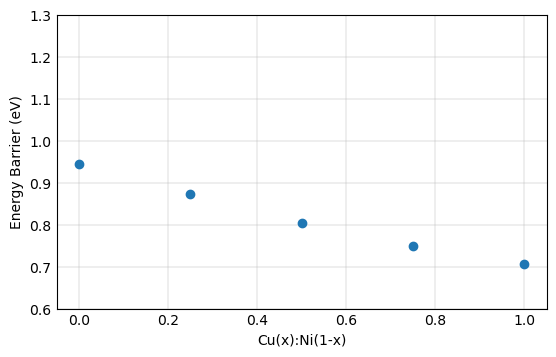

In [ ]:
fig, axs = plt.subplots(1,1, figsize = (5,3))

axs.scatter(xVals, results)
axs.set_xlabel('Cu(x):Ni(1-x)')
axs.set_ylabel('Energy Barrier (eV)')
axs.set_ylim([0.6,1.3])

axs.grid(True, linewidth=0.3)